In [97]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot
import numpy as np
from datetime import datetime, timedelta
import pandas_datareader as pdr
import plotly.graph_objects as go
from datetime import date
from dateutil.relativedelta import relativedelta
from pytrends.request import TrendReq
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from IPython import display

In [98]:
#Constants
CRYPTO1_FILEPATH = ''
CRYPTO2_FILEPATH = ''
CRYPTO3_FILEPATH = ''
GOLD_FILEPATH = ''
CRUDE_OIL_FILEPATH = ''
CRYPTO1='BTC'
CRYPTO2='ETH'
CRYPTO3='LTC'
GOLD='GC=F'
CRUDE_OIL='CL=F'
KEY1="Bitcoin"
KEY2="Cryptocurrency"
KEY3="Dogecoin"
CURRENCY = 'USD'
TIMEFRAME = 'today 3-m'
XLABEL = "DATE"
CRYPTO=[CRYPTO1,CRYPTO2,CRYPTO3]
COMMODITY=[GOLD,CRUDE_OIL]
ALL=CRYPTO+COMMODITY
ALL_2D=[(CRYPTO1,CRYPTO1_FILEPATH),(CRYPTO2,CRYPTO2_FILEPATH),(CRYPTO3,CRYPTO3_FILEPATH),(GOLD,GOLD_FILEPATH),(CRUDE_OIL,CRUDE_OIL_FILEPATH)]

In [99]:
## Function to extract data for different cryptocurrencies from Yahoo Finance
def getData1(cryptocurrency):
    now = datetime.now()
    current_date = now.strftime("%Y-%m-%d")
    last_year_date = (now - timedelta(days=90)).strftime("%Y-%m-%d")

    start = pd.to_datetime(last_year_date)
    end = pd.to_datetime(current_date)

    data = pdr.get_data_yahoo(f'{cryptocurrency}-{CURRENCY}', start, end)

    return data

## Function to extract data for different commodities from Yahoo Finance
def getData2(commodity):
    now = datetime.now()
    current_date = now.strftime("%Y-%m-%d")
    last_year_date = (now - timedelta(days=90)).strftime("%Y-%m-%d")

    start = pd.to_datetime(last_year_date)
    end = pd.to_datetime(current_date)

    data = pdr.get_data_yahoo(commodity, start, end)

    return data

## Function to read data from Yahoo Finance
def readCryptoDataFromYahooFinance():
    dataframe_collection = {} 
    for x in CRYPTO:
        new_data=getData1(x)
        new_data=new_data.reset_index()
        dataframe_collection[x] = pd.DataFrame(new_data)
        
    for x in COMMODITY:
        new_data=getData2(x)
        new_data=new_data.reset_index()
        dataframe_collection[x] = pd.DataFrame(new_data)
    
    return dataframe_collection

## Function to read data from the file paths given
def readDataFiles():
    dataframe_collection = {} 
    for x,y in ALL_2D:
        new_data=pd.read_csv(y, encoding = "ISO-8859-1")
        dataframe_collection[x] = pd.DataFrame(new_data)
    
    return dataframe_collection

## Function to create a dataframe
def createDataFrameFromStructure(structure):
    return pd.DataFrame(structure)

## Function for setting the date for the graphs 
def adding_date_for_a_date_time_graph(df):
    ## Adding date for a date time graph 
    date_time1 = df['Date']
    date_time1 = pd.to_datetime(date_time1)

    ## Adding data for a date time graph
    dframe=pd.DataFrame(df[df.columns.difference(['Date'])])
    dframe = dframe.set_index(date_time1)
    return dframe

## Function to plot a graph for absolute changes in closing prices
def plotGraph(dframe, Ylabel, XLabel, Legend):
    plt.plot(dframe)
    plt.ylabel(Ylabel, color="purple")
    plt.xlabel(XLabel, color="purple")
    plt.legend(Legend);
    plt.gcf().autofmt_xdate()
    plt.show()
    
## Function to show correlation of closing prices using Pearson correlation
def create_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 5))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

## Funtion to plot the graph for relative changes in closing prices
def plotgraph_relative_prices(dframe, Xlabel, Ylabel, Legend):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    rspine = ax2.spines['right']
    rspine.set_position(('axes', 1.15))
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    dframe[CRYPTO1].plot(ax=ax1, style='b-')
    dframe[CRYPTO2].plot(ax=ax1, style='r-', secondary_y=True)
    dframe[CRYPTO3].plot(ax=ax2, style='g-')
    
    ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
            Legend)
    
    ax1.set_xlabel(XLABEL,color='purple')
    ax1.set_ylabel(YLABEL[0],color = 'purple')
    ax1.right_ax.set_ylabel(YLABEL[1],color = 'purple')
    ax2.set_ylabel(YLABEL[2],color = 'purple')
    
## Function to calculate buy and hold status of cryptocurrencies 
def buy_and_hold(df,date_time1):
    dframe2=pd.DataFrame(df[df.columns.difference(['Date'])])
    dframe2 = dframe2.set_index(date_time1)
    return dframe2.apply(lambda x: x / x[0])

## Function to plot graph that shows the holding period return
def plotgraph_returns(df_return,XLABEL,YLABEL):
    ax=df_return.plot(grid=True, figsize=(10, 5))
    ax.axhline(y = 1, color = "black", lw = 2)
    ax.set_xlabel(XLABEL,color="purple")
    ax.set_ylabel(YLABEL,color="purple")

## Function to create a pytrends object 
def pytrends_object(kw_list):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe= TIMEFRAME, geo='', gprop='')
    return pytrends.interest_over_time()

## Function to scale the values of the dataframe created by the pytrends object
def scaling(data,DIFFERENCE):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    return scaler.fit_transform(data[data.columns.difference(DIFFERENCE)])

## Function to create a dataframe with scaled values
def dataframe_with_scaled_up_values(scaled,scaled2):
    df3=pd.DataFrame(scaled)
    df3_2 = pd.DataFrame(scaled2)
    df3.columns =[KEY1, KEY2, KEY3]
    df3_2.columns =[CRYPTO1]
    df3.insert(0, 'Date', data['date'].values)
    df3.insert(1, CRYPTO1, df3_2[CRYPTO1].values)
    return df3

## Function to plot graph that shows search frequency in comparison to Bitcoin closing prices
def plotgraph_search_frequency(data1,data2,date_time,Key):
    DF = pd.DataFrame()
    DF['value1'] = data1
    DF['value2'] = data2
    DF = DF.set_index(date_time)
    plt.plot(DF)
    plt.ylabel("Prices and Search Frequency(Scaled)",color="purple")
    plt.xlabel("DATE",color="purple")
    plt.legend(["Bitcoin Prices", Key]);
    plt.gcf().autofmt_xdate()
    plt.show()

## Function to prepare data for predicting closing prices of cryptocurrencies
def data_for_price_prediction(name_list, df_list):
    df1_list= {}
    for i in range(0, len(df_list)):
        df1_list[name_list[i]] = pd.DataFrame({"ds": df_list[i].Date,
                                   "y": df_list[i].Close})
    return df1_list

## Function to predict closing prices of cryptocurrencies
def prediction_prices(name_list,df1_list):
    prophet= {}
    future= {}
    forecast= {}
    for i in range(0, len(df1_list)):
        prophet[name_list[i]] = Prophet()
        prophet[name_list[i]].fit(df1_list[i])
        
        ## Predictions for the next 60 days
        future[name_list[i]] = prophet[name_list[i]].make_future_dataframe(periods=60)

        forecast[name_list[i]] = prophet[name_list[i]].predict(future[name_list[i]])

    return forecast, prophet
 
## Function to plot graph that shows the forecasted data for cryptocurrencies
def plotgraph_forecasted_data(forecast,prophet):
    ## Prediction of closing prices for Bitcoin
    prophet.plot(forecast, figsize=(10, 5));

## Function to plot a candlestick graph for Bitcoin
def candlestick_chart(CRYPTO):
    crypto_data = getData1(CRYPTO)

    # Candlestick
    fig = go.Figure(
        data = [
            go.Candlestick(
                x = crypto_data.index,
                open = crypto_data.Open,
                high = crypto_data.High,
                low = crypto_data.Low,
                close = crypto_data.Close
            ),
            go.Scatter(
                x = crypto_data.index, 
                y = crypto_data.Close.rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = crypto_data.index, 
                y = crypto_data.Close.rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            )
        ]
    )
    
    fig.update_layout(
    title = f'The Candlestick graph for {CRYPTO}',
    xaxis_title = 'Date',
    yaxis_title = f'Price ({CURRENCY})',
    xaxis_rangeslider_visible = False
    )
    fig.update_yaxes(tickprefix='$')

    fig.show()
    

In [100]:
## Reading data 
flag=int(input("Press 0 if u wish to upload datafiles\nPress 1 if you wish to read crypto data from Yahoo Finance?\n"))
if flag==0:
    dfs=readDataFiles()
    df_btc, df_eth, df_ltc, df_gold, df_crude=[dfs[x] for x in ALL]
elif flag==1:
    dfs=readCryptoDataFromYahooFinance()
    df_btc, df_eth, df_ltc, df_gold, df_crude= [dfs[x] for x in ALL]
else :
    print("Wrong Input")

Press 0 if u wish to upload datafiles
Press 1 if you wish to read crypto data from Yahoo Finance?
1


In [101]:
## Extracting closing prices for Bitcoin, Ethereum and Litecoin
CryptoStructure = {'Date': df_btc.Date,
                   CRYPTO1: df_btc.Close,
                   CRYPTO2: df_eth.Close,
                   CRYPTO3: df_ltc.Close};
df=createDataFrameFromStructure(CryptoStructure)

In [102]:
## Counting the number of events and calculating mean, standard deviation, minimum, quartiles, and maximum closing price.
print(df.describe())
dframe=adding_date_for_a_date_time_graph(df)

                BTC          ETH         LTC
count     92.000000    92.000000   92.000000
mean   54129.624873  2304.604971  235.999768
std     5721.182328   728.334169   54.948372
min    37002.441406  1416.048950  164.927170
25%    50008.284180  1786.876556  191.635544
50%    55962.128906  2100.505005  220.949226
75%    58202.348633  2566.577576  269.620049
max    63503.457031  4168.701172  386.450775


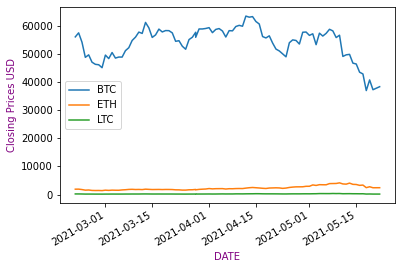

In [103]:
## Absolute Closing prices 
YLABEL = "Closing Prices USD"
Legend = CRYPTO
plotGraph(dframe, YLABEL, XLABEL, Legend)

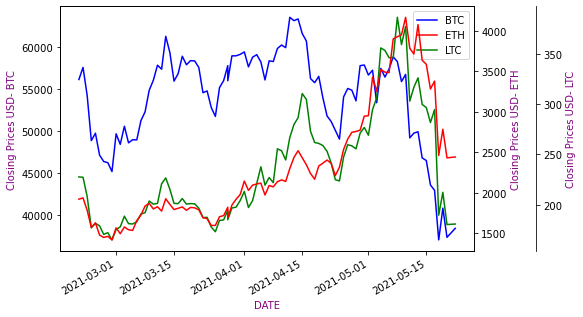

In [104]:
## Relative changes in closing prices
Legend=CRYPTO
YLABEL=["Closing Prices USD- BTC","Closing Prices USD- ETH","Closing Prices USD- LTC"]
plotgraph_relative_prices(dframe, XLABEL, YLABEL, Legend)

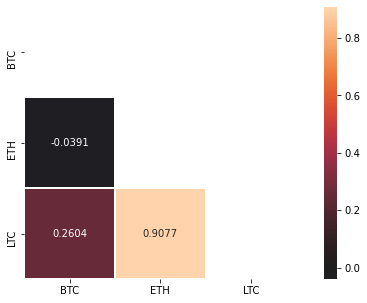

In [105]:
## Pearson Correlation
create_correlation_matrix(df)

In [106]:
## Extracting closing prices for Gold, Bitcoin and Crude Oil
CryptoCommodityStruct={ "Date": df_btc.Date,
                        "BTC": df_btc.Close,
                        "Gold": df_gold.Close,
                        "Crude Oil": df_crude.Close}
df2=createDataFrameFromStructure(CryptoCommodityStruct)
df2.describe()
df2=df2.dropna()

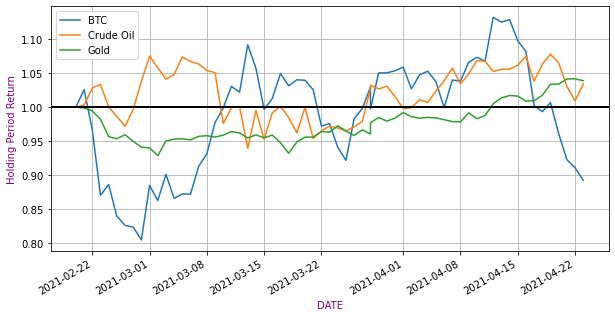

In [107]:
## Buy and Hold strategy of BTC, Crude Oil and Gold
date_time1 = df2['Date']
df2_return=buy_and_hold(df2,date_time1)

## Visualize Returns(Performance) of Bitcoin in comparison to Gold and Crude Oil
YLABEL="Holding Period Return"
plotgraph_returns(df2_return,XLABEL,YLABEL)

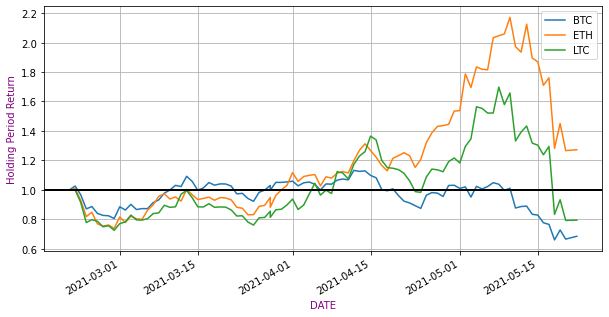

In [108]:
## Buy and Hold Strategy for different cryptocurrencies
df_return = dframe.apply(lambda x: x / x[0])

## Visualize Returns for different cryptocurrencies
YLABEL="Holding Period Return"
plotgraph_returns(df_return,XLABEL,YLABEL)

In [109]:
## Create a pytrends object, request data from Google Trends
kw_list = [KEY1,KEY2,KEY3]

data=pytrends_object(kw_list)
data=data.reset_index()

df_btc_series=pd.Series(df[CRYPTO1].values)
data.insert(0, CRYPTO1, df_btc_series )

In [110]:
## Scaling search frequency and closing price
DIFFERENCE1=['date','isPartial','BTC']
DIFFERENCE2=['date','isPartial','Dogecoin', 'Bitcoin', 'Cryptocurrency']

scaled=scaling(data,DIFFERENCE1)
scaled2=scaling(data,DIFFERENCE2)

In [111]:
## Creating a dataframe with the scaled up values for all the keywords and Bitcoin closing prices
df3=dataframe_with_scaled_up_values(scaled,scaled2)

## Adding date and data for a date time graph 
date_time = df3['Date']
date_time = pd.to_datetime(date_time)
data2 = df3[CRYPTO1]

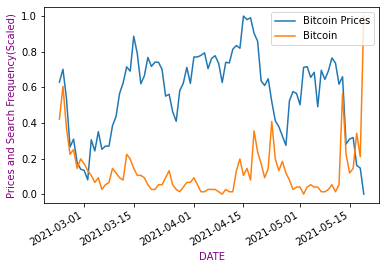

In [112]:
## Affect of search frequency of keyword 1 on closing prices of Bitcoin 
data3 = df3[KEY1]

plotgraph_search_frequency(data2,data3,date_time,KEY1)

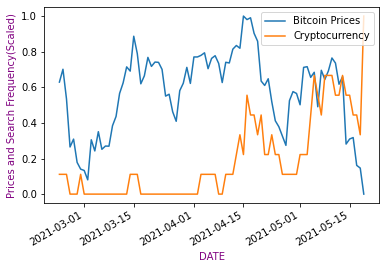

In [113]:
## Affect of search frequency of keyword 2 on closing prices of Bitcoin 
data4 = df3[KEY2]

plotgraph_search_frequency(data2,data4,date_time,KEY2)

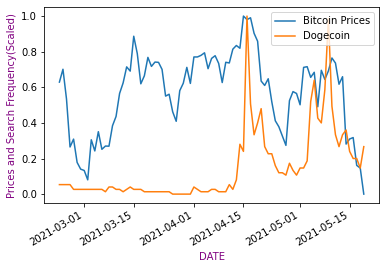

In [114]:
## Affect of search frequency of keyword 3 on closing prices of Bitcoin 
data5 = df3[KEY3]

plotgraph_search_frequency(data2,data5,date_time,KEY3)

In [115]:
## Preparing data for Cryptocurrency Price Prediction
df_list=[df_btc,df_eth,df_ltc]
dfs_list=data_for_price_prediction(CRYPTO, df_list)
df1_btc,df1_eth,df1_ltc=[dfs_list[x] for x in CRYPTO] 

## Forecasting/Predicting prices for BTC, ETH and LTC
df1_list=[df1_btc,df1_eth,df1_ltc]
forecast_list, prophet_list=prediction_prices(CRYPTO, df1_list)
forecast_btc, forecast_eth, forecast_ltc=[forecast_list[x] for x in CRYPTO] 
prophet_btc, prophet_eth, prophet_ltc=[prophet_list[x] for x in CRYPTO] 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


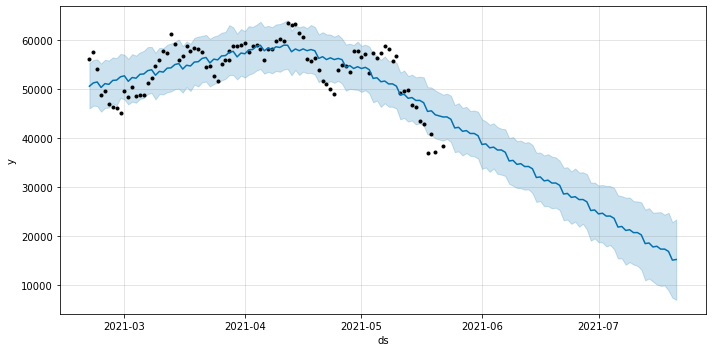

In [116]:
## Forecasted data for Bitcoin
plotgraph_forecasted_data(forecast_btc,prophet_btc)

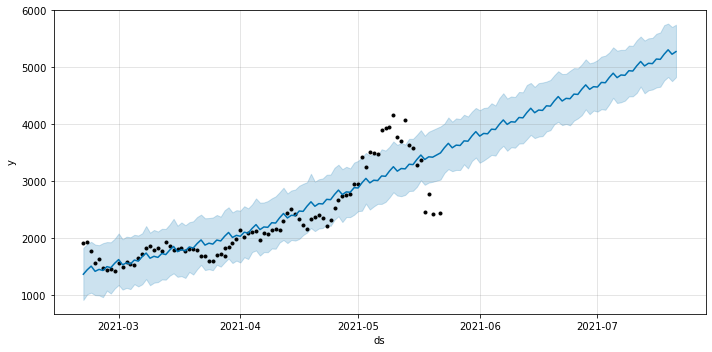

In [117]:
## Forecasted data for Ethereum
plotgraph_forecasted_data(forecast_eth,prophet_eth)

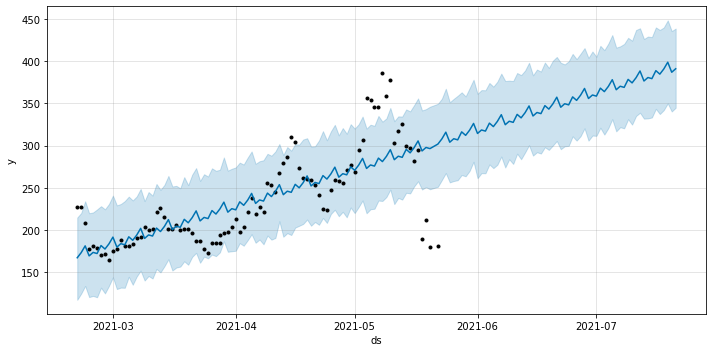

In [118]:
## Forecasted data for Litecoin
plotgraph_forecasted_data(forecast_ltc,prophet_ltc)

In [119]:
## Plotting a candlestick chart for Bitcoin
candlestick_chart(CRYPTO1)

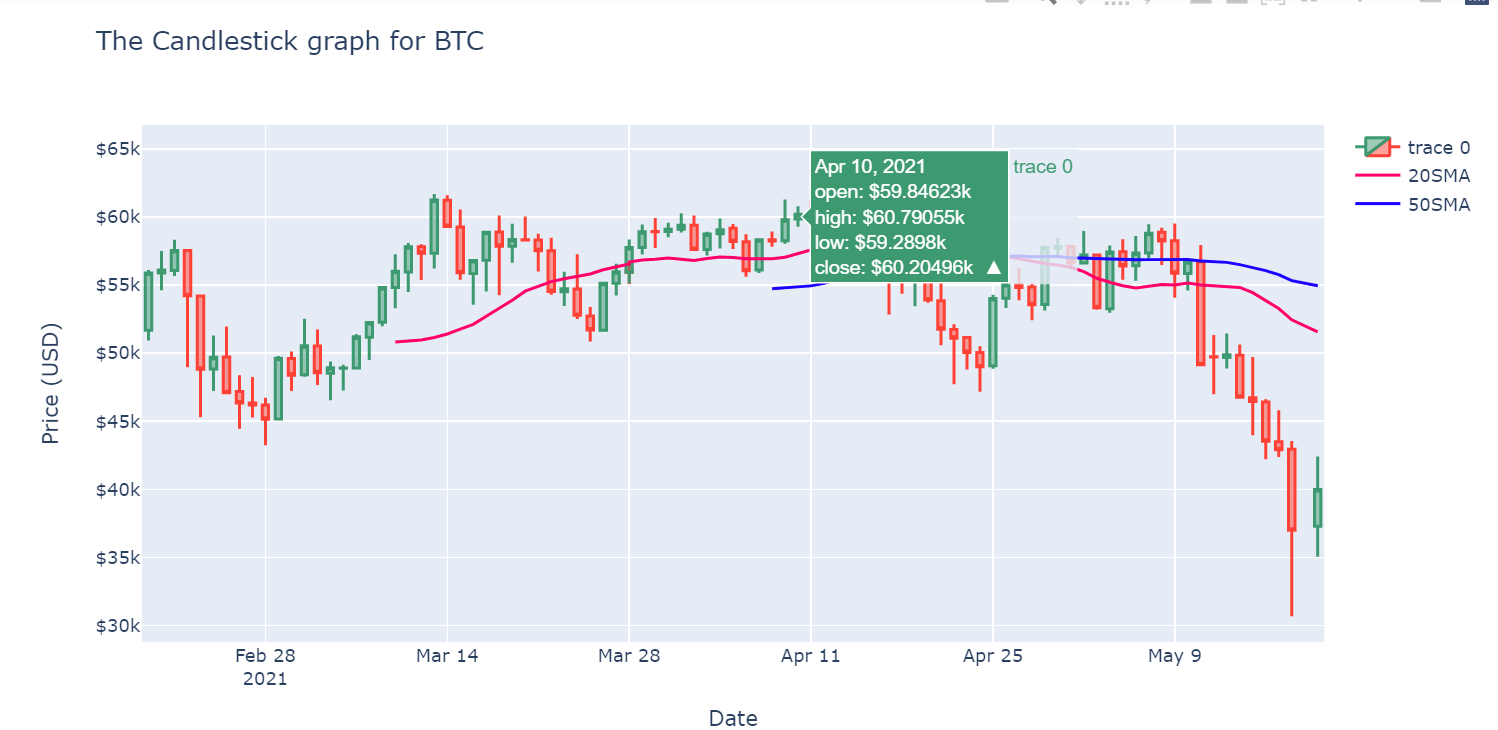

In [120]:
## As GITHUB doesn't support the candlestick graph, here is the image of the executed code for reference.
display.Image("D:\Cryptocurrency\Candlestick_graph.png")